# Setup

In [1]:
# Imports
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import skimage.data
import skimage.filters
import skimage.io

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage

import umap
import umap.plot

try:
    import seaborn as sns
    sns.set()
except:
    pass

c:\Users\Xyrion\Anaconda3\envs\deep\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Image functions

# Image crop
def center_crop(array):
    width, height = array.shape[0], array.shape[1]
    if width == height:
        return array
    if width < height:
        diff = height - width
        start = math.floor(diff / 2)
        end = math.ceil(diff / 2)
        return array[:, start:-end]
    if width > height:
        diff = width - height
        start = math.floor(diff / 2)
        end = math.ceil(diff / 2)
        return array[start:-end, :]

# Image -> Tensor
def image_to_tensor(input_array):
    # Normalize input
    input_array = input_array - [0.485, 0.456, 0.406]
    input_array = input_array / [0.229, 0.224, 0.225]
 
    # Turn from (width, height, channel) into (batch, channel, width, height) and convert to tensor
    input_tensor = torch.Tensor((input_array.transpose([2, 0, 1]))[None, ...])
 
    return input_tensor

# Tensor -> Image
def tensor_to_image(tensor):
    # Turn from (batch, channel, width, height) tensor into (width, height, channel) array
    array = tensor[0].detach().numpy().transpose([1, 2, 0])

    # Denormalize
    array = array * [0.229, 0.224, 0.225]
    array = array + [0.485, 0.456, 0.406]

    # Clip
    np.clip(array, 0.0, 1.0, out=array)

    return array

In [4]:
# Difference plotting function
def show_diffs(model, original_tensor, modified_tensor, label_names):
    # Images and predictions
    original_image = original_tensor.view(28, 28).detach()
    modified_image = modified_tensor.view(28, 28).detach()
    original_label = model(original_tensor)[0].argmax().item()
    modified_label = model(modified_tensor)[0].argmax().item()

    # Prepare figure
    n_rows, n_cols = 1, 3
    image_figure, image_axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    plot_figure, plot_axes = plt.subplots(n_rows, n_cols-1, figsize=(n_cols * 3, n_rows * 2), sharex=True)

    # Show original image
    ax = image_axes[0]
    ax.imshow(original_image)
    ax.grid(False); ax.axis('off'); ax.set_title(label_names[original_label].split(',')[0])

    # Show perturbation
    ax = image_axes[1]
    ax.imshow(calc_perturbation(original_image, modified_image))
    ax.grid(False); ax.axis('off'); ax.set_title('perturbation')

    # Show perturbed image
    ax = image_axes[2]
    ax.imshow(modified_image)
    ax.grid(False); ax.axis('off'); ax.set_title(label_names[modified_label].split(',')[0])

    original_certainty = F.softmax(model(original_tensor)[0], dim=0).detach().numpy()
    ax = plot_axes[0]
    ax.bar(range(len(label_names)), original_certainty, edgecolor='gray')
    ax.set_xlabel('label'); ax.set_ylabel('certainty')

    modified_certainty = F.softmax(model(modified_tensor)[0], dim=0).detach().numpy()
    ax = plot_axes[1]
    ax.bar(range(len(label_names)), modified_certainty, edgecolor='gray')
    ax.set_xlabel('label'); ax.set_ylabel('certainty')

    plt.tight_layout()

def calc_perturbation(original_image, modified_image):
    perturbation = modified_image - original_image
    perturbation -= perturbation.min()
    perturbation /= perturbation.max()
    return perturbation

### Train model

In [6]:
# Prepare training and test data
training_data = datasets.FashionMNIST( root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
train_data_loader = DataLoader(training_data, batch_size=128)
test_data_loader = DataLoader(test_data, batch_size=128)

In [5]:
fashion_labels = {0: 'T-Shirt',
                  1: 'Trowser',
                  2: 'Pullover',
                  3: 'Dress',
                  4: 'Coat',
                  5: 'Sandal',
                  6: 'Shirt',
                  7: 'Sneaker',
                  8: 'Bag',
                  9: 'Ankle Boot'}

In [7]:
# Define network
class FashionNetwork(nn.Module):
    def __init__(self):
        super(FashionNetwork, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
 
    def forward(self, x):
        return self.conv_stack(x)

In [8]:
def train_loop(data_loader, model, loss_function, optimizer):
    mean_loss, n_correct = 0, 0

    for batch, (data, labels) in enumerate(data_loader):
        # Feed data through network and compute loss.
        prediction = model(data)
        loss = loss_function(prediction, labels)
 
        # Zero gradients.
        optimizer.zero_grad()
 
        # Perform backpropagation and accumulate gradients.
        loss.backward()
 
        # Update network parameters.
        optimizer.step()

        mean_loss += loss.detach().item()
        n_correct += (prediction.argmax(1) == labels).type(torch.float).sum().item()
    
    return n_correct / len(data_loader.dataset), mean_loss / len(data_loader)

def test_loop(data_loader, model, loss_function):
    mean_loss, n_correct = 0, 0
 
    with torch.no_grad():
        for data, labels in data_loader:
            # Feed data through network and accumulate loss.
            prediction = model(data)
            
            mean_loss += loss_function(prediction, labels).item()
            n_correct += (prediction.argmax(1) == labels).type(torch.float).sum().item()
 
    return n_correct / len(data_loader.dataset), mean_loss / len(data_loader)

In [13]:
model = FashionNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 5

In [14]:
for epoch in range(n_epochs):
    print(f' Epoch {epoch+1:02}: ', end='\t')
    train_acc, train_loss = train_loop(train_data_loader, model, loss_fn, optimizer)
    print(f'Train Accuracy: {train_acc:.2%},', f'Train Loss: {train_loss:.4}', end=',\t')
    test_acc, test_loss = test_loop(test_data_loader, model, loss_fn)
    print(f'Test Accuracy: {test_acc:.2%},', f'Test Loss: {test_loss:.4}')

 Epoch 01: 	Train Accuracy: 73.58%, Train Loss: 0.7327,	Test Accuracy: 79.46%, Test Loss: 0.5483
 Epoch 02: 	Train Accuracy: 82.90%, Train Loss: 0.4747,	Test Accuracy: 83.06%, Test Loss: 0.46
 Epoch 03: 	Train Accuracy: 85.40%, Train Loss: 0.4095,	Test Accuracy: 84.73%, Test Loss: 0.417
 Epoch 04: 	Train Accuracy: 86.59%, Train Loss: 0.372,	Test Accuracy: 85.71%, Test Loss: 0.3935
 Epoch 05: 	Train Accuracy: 87.41%, Train Loss: 0.3452,	Test Accuracy: 86.42%, Test Loss: 0.375


In [15]:
model.eval();

# Task 1

### 1.1 Untargeted attack

#### 1.1.1 Select image

In [13]:
IMG_NR = 11

image, label = training_data[IMG_NR]
modified_tensor = image.view(1, 1, 28, 28)
original_tensor = torch.clone(modified_tensor)

display(ToPILImage()(image.squeeze_(0)))
print('Real Label:      ', fashion_labels[label])
print('Predicted Label: ', fashion_labels[model(original_tensor)[0].argmax().item()])

Real Label:       Ankle Boot
Predicted Label:  Ankle Boot


#### 1.1.2 Attack

In [14]:
# Prepare input image
modified_tensor = modified_tensor.requires_grad_()

# Pass input through network
prediction_tensor = model(modified_tensor)

# Prepare target
original_label = prediction_tensor[0].argmax().item()
target_tensor = torch.tensor([original_label], dtype=torch.long)

# Loss
loss = torch.nn.CrossEntropyLoss()
loss_value = loss(prediction_tensor, target_tensor)

# Zero gradients
model.zero_grad()
modified_tensor.grad = None

# Propagate error backwards through the network
loss_value.backward()

In [15]:
# Modify input

attack_scale = 0.5 * 0.5
new_label = original_label
while new_label == original_label:
    print('#', end='')
    attack_scale *= 2.0
    modified_tensor.data += attack_scale * modified_tensor.grad.data

    # Clamp modified input such that it corresponds to an image
    modified_tensor.data[:, 0, :, :].clamp_(-0.485 / 0.229, (1 - 0.485) / 0.229)

    # Pass modified input through network and determine 'winning' label
    prediction_tensor = model(modified_tensor)[0]
    new_label = prediction_tensor.argmax().item()

#####

#### 1.1.3 Show result

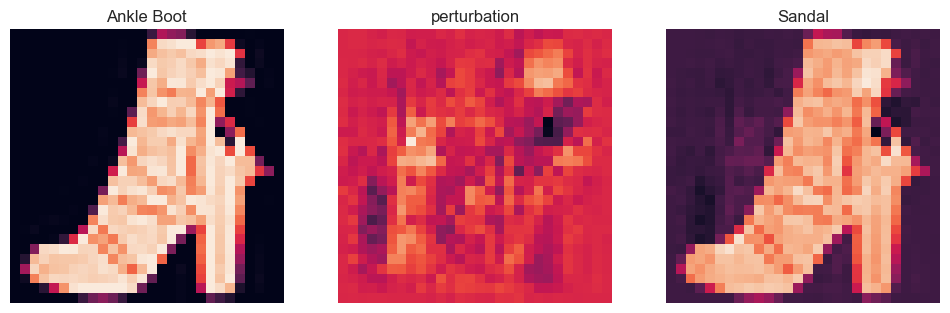

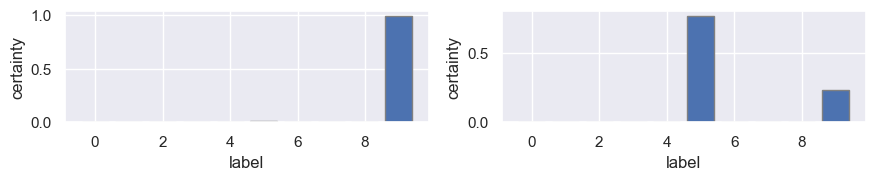

In [16]:
show_diffs(model, original_tensor, modified_tensor, fashion_labels)

### 1.2 Targeted attack

#### 1.2.1 UMAP analysis

torch.Size([70000, 784])
70000


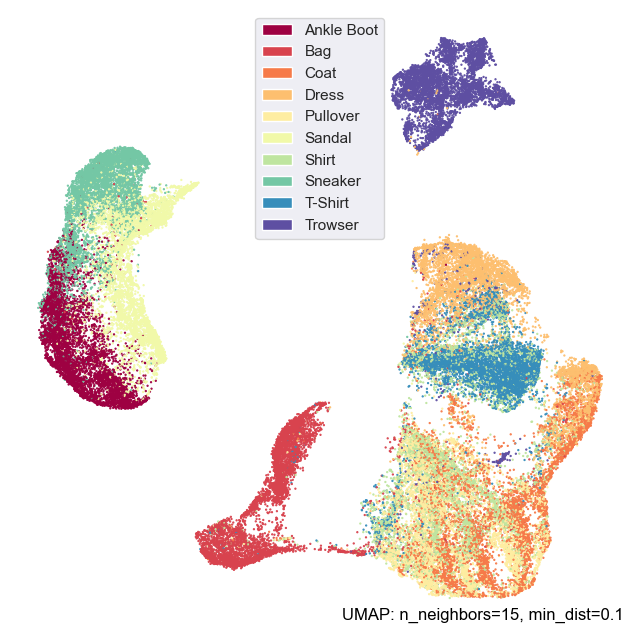

In [17]:
images = torch.stack(list(zip(*training_data))[0] + list(zip(*test_data))[0]).view(70000, 28*28)
targets = [fashion_labels[i] for i in torch.cat([training_data.targets, test_data.targets]).detach().numpy()]
print(images.shape)
print(len(targets))

mapper = umap.UMAP().fit(pd.DataFrame(images[:60000].detach()))
umap.plot.points(mapper, labels=np.array(targets[:60000]));

#### 1.2.2 Attack function

In [18]:
def do_target_attack(model, dataset, starting_class, targeted_class, attack_scale=0.001):
    image = find_image(dataset, starting_class)
    modified_tensor = image.view(1, 1, 28, 28).requires_grad_()
    original_tensor = torch.clone(modified_tensor)

    # Pass input through network
    prediction_tensor = model(modified_tensor)

    # Prepare target
    original_label = prediction_tensor[0].argmax().item()
    target_tensor = torch.tensor([targeted_class], dtype=torch.long)

    # Loss
    loss = torch.nn.CrossEntropyLoss()
    loss_value = loss(prediction_tensor, target_tensor)

    # Zero gradients
    model.zero_grad()
    modified_tensor.grad = None

    # Propagate error backwards through the network
    loss_value.backward()

    # Modify input
    iteration_count = 0
    new_label = original_label
    while new_label != targeted_class:
        print('#', end='')
        iteration_count += 1
        attack_scale *= 2.0
        modified_tensor.data -= attack_scale * modified_tensor.grad.data

        # Clamp modified input such that it corresponds to an image
        modified_tensor.data[:, 0, :, :].clamp_(-0.485 / 0.229, (1 - 0.485) / 0.229)

        # Pass modified input through network and determine 'winning' label
        prediction_tensor = model(modified_tensor)[0]
        new_label = prediction_tensor.argmax().item()
    print(f'\nFinished after {iteration_count} iterations.')

    return original_tensor, modified_tensor

# Get an image from a given target label
def find_image(dataset, target):
    for (image, label) in dataset:
        if label == target:
            return image

#### 1.2.3 Attacks

########
Finished after 8 iterations.


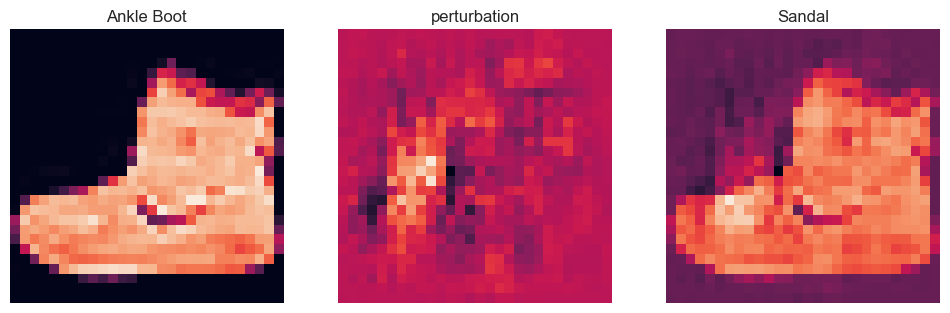

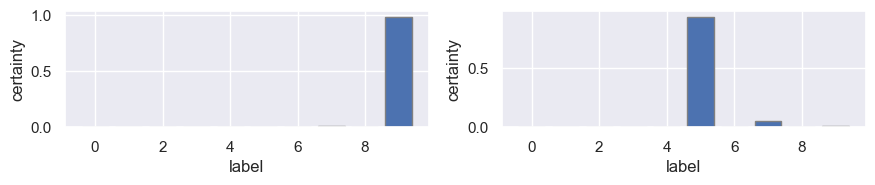

In [19]:
ord_tensor, mod_tensor = do_target_attack(model, training_data, 9, 5)
show_diffs(model, ord_tensor, mod_tensor, fashion_labels)

#########
Finished after 9 iterations.


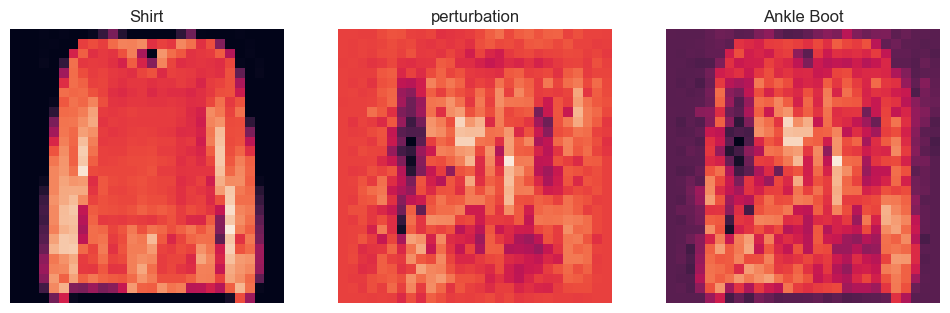

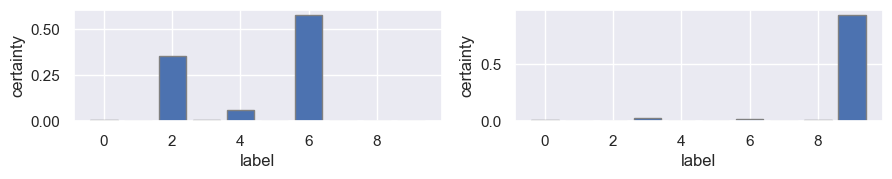

In [25]:
ord_tensor, mod_tensor = do_target_attack(model, training_data, 6, 9)
show_diffs(model, ord_tensor, mod_tensor, fashion_labels)

########
Finished after 8 iterations.


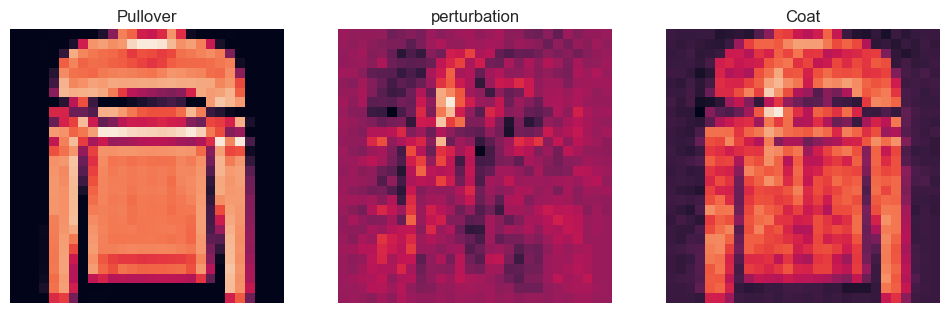

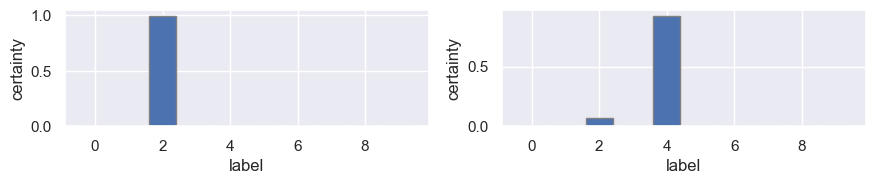

In [22]:
ord_tensor, mod_tensor = do_target_attack(model, training_data, 2, 4)
show_diffs(model, ord_tensor, mod_tensor, fashion_labels)

########
Finished after 8 iterations.


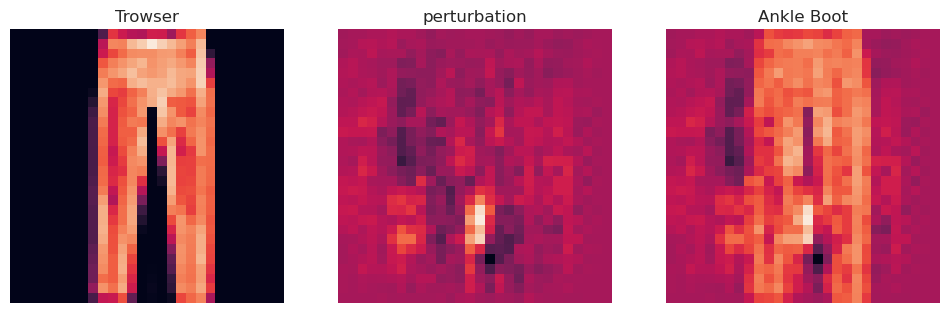

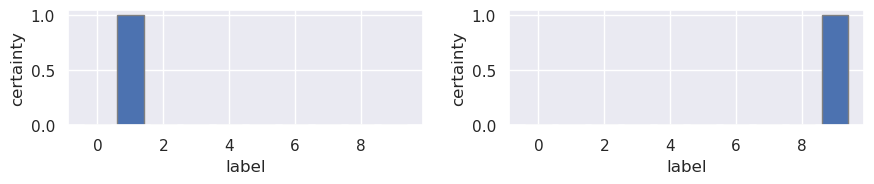

In [ ]:
ord_tensor, mod_tensor = do_target_attack(model, training_data, 1, 9)
show_diffs(model, ord_tensor, mod_tensor, fashion_labels)

#######
Finished after 7 iterations.


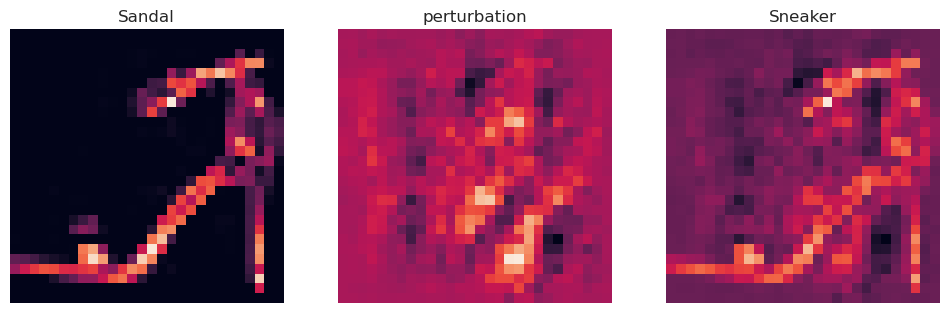

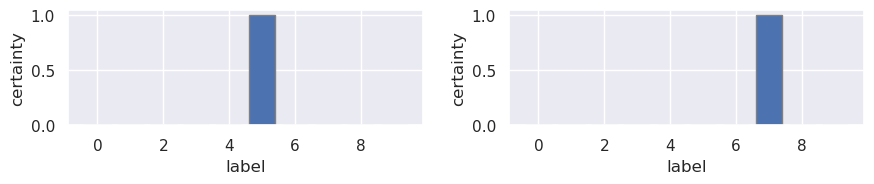

In [ ]:
ord_tensor, mod_tensor = do_target_attack(model, training_data, 5, 7)
show_diffs(model, ord_tensor, mod_tensor, fashion_labels)

########
Finished after 8 iterations.


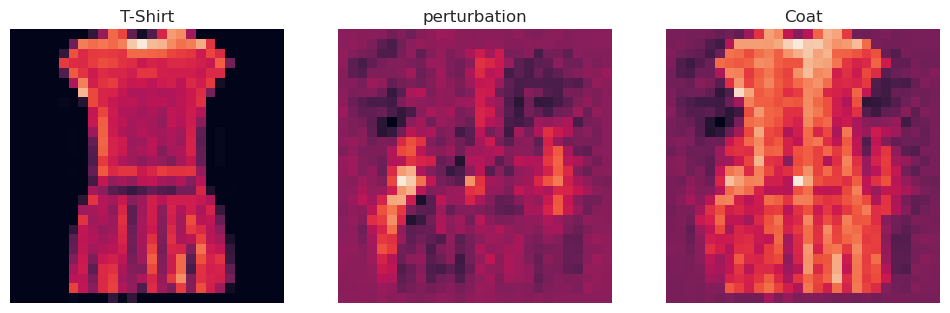

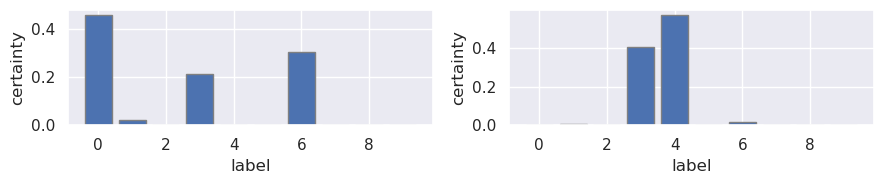

In [ ]:
ord_tensor, mod_tensor = do_target_attack(model, training_data, 3, 4)
show_diffs(model, ord_tensor, mod_tensor, fashion_labels)

# Task 2

In [2]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt

In [17]:
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds)
images, labels = fb.utils.samples(fmodel, dataset='fashionMNIST', batchsize=16)
# images, labels = fb.utils.samples(fmodel, dataset='fashionMNIST', batchsize=64)
clean_acc = fb.utils.accuracy(fmodel, images, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")

clean accuracy:  87.5 %


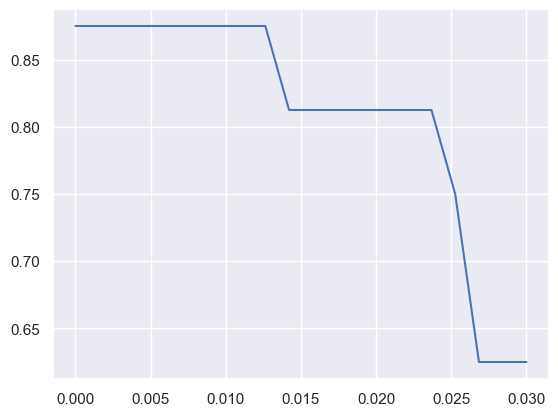

In [18]:
epsilons = np.linspace(0.0, 0.03, num=20)
# attack = fb.attacks.LinfDeepFoolAttack()
attack = fb.attacks.FGSM()
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
robust_accuracy = 1 - is_adv.float().mean(axis=-1)

plt.plot(epsilons, robust_accuracy.cpu().numpy())


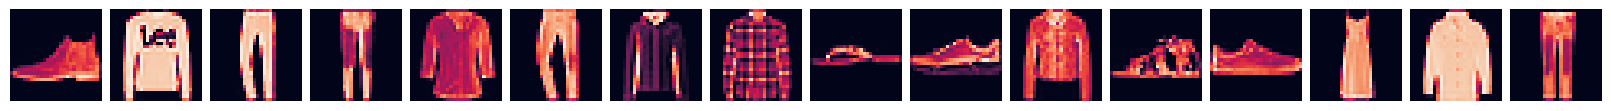

In [90]:
fb.plot.images(images=images)

In [64]:
fb.distances.l2(images, raw[19])

tensor([0.4985, 1.2512, 3.8590, 2.8591, 0.6761, 2.3773, 0.5603, 0.0116, 0.3547,
        0.9177, 0.8623, 0.9512, 0.0000, 1.7952, 0.4541, 1.3501, 0.8175, 0.0000,
        1.7884, 1.5532, 0.4985, 1.2512, 3.8590, 2.8591, 0.6761, 2.3773, 0.5603,
        0.0116, 0.3547, 0.9177, 0.8623, 0.9512], device='cuda:0')

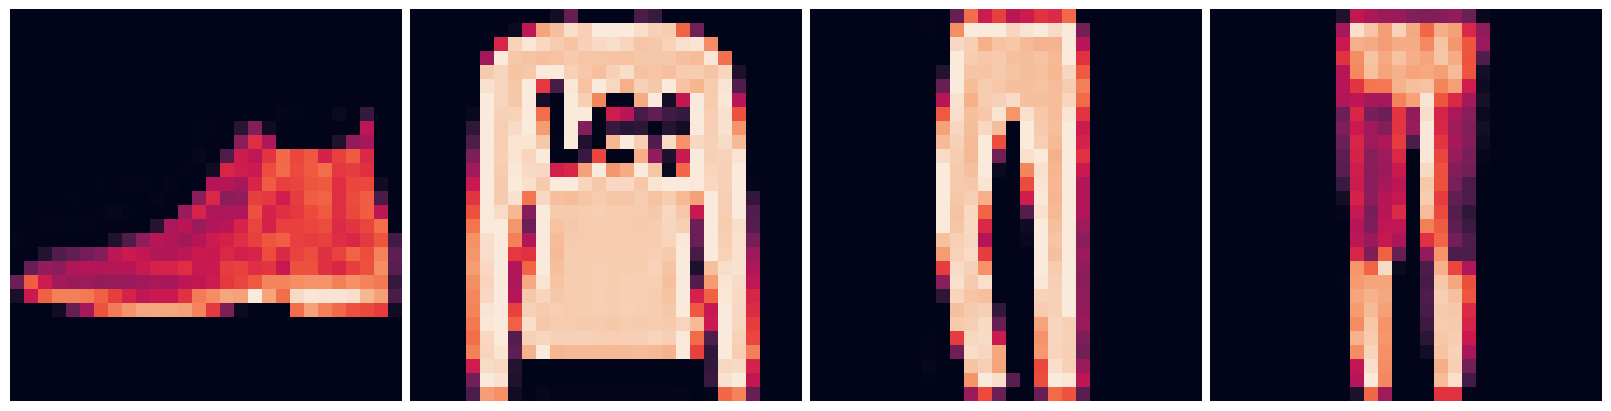

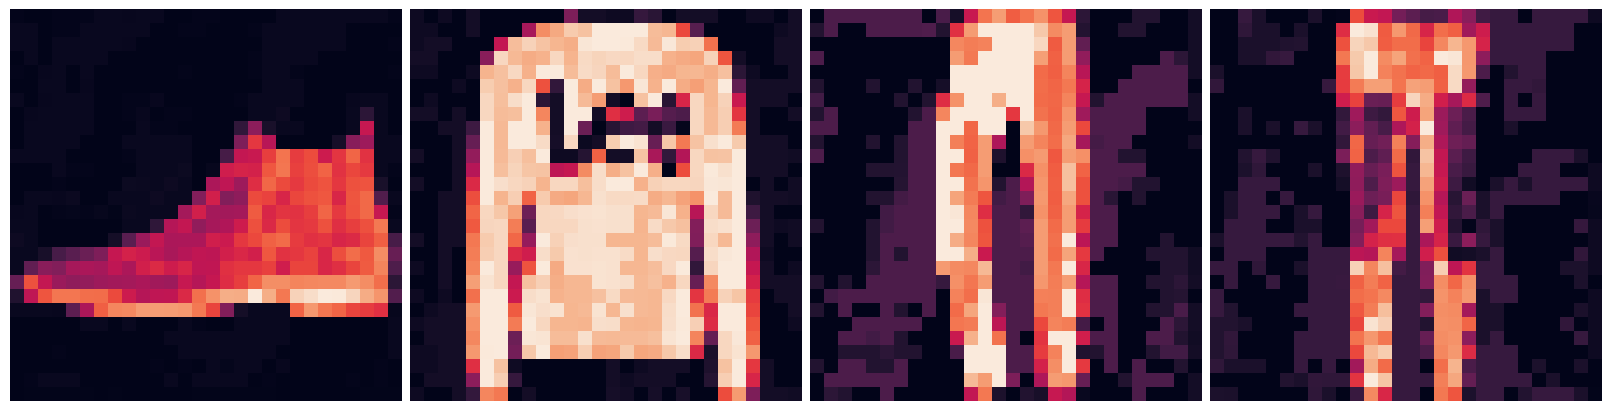

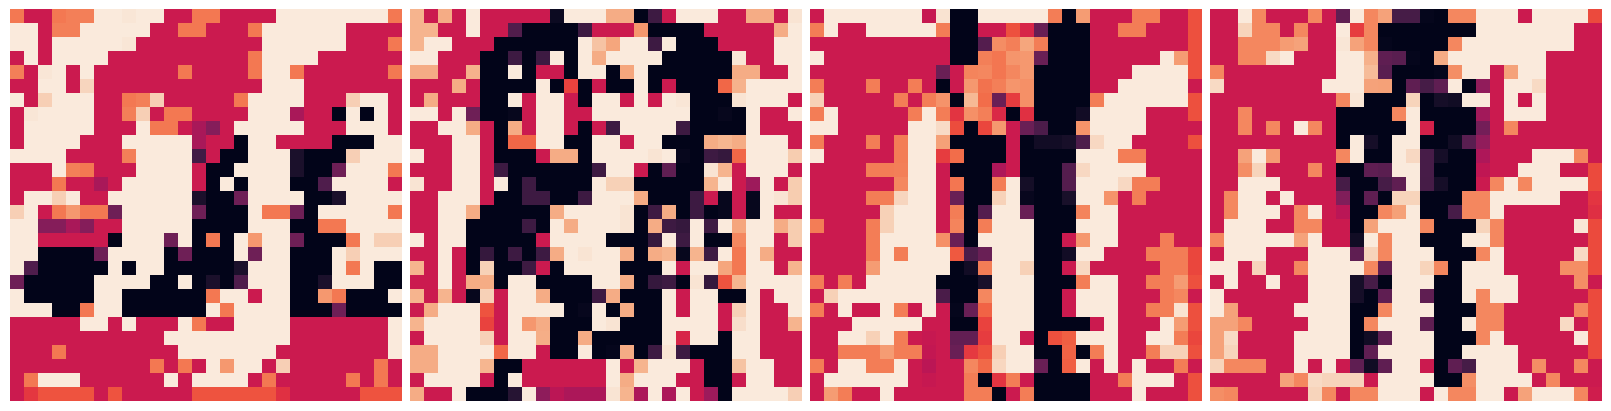

In [116]:
fb.plot.images(images=images, n=4, bounds=(-0.1, 0.1), scale=4.)
# fb.plot.images(images=raw[0])
fb.plot.images(images=raw[19], n=4, bounds=(-0.1, 0.1), scale=4.)
fb.plot.images(raw[19] - images, n=4, bounds=(-0.1, 0.1), scale=4.)

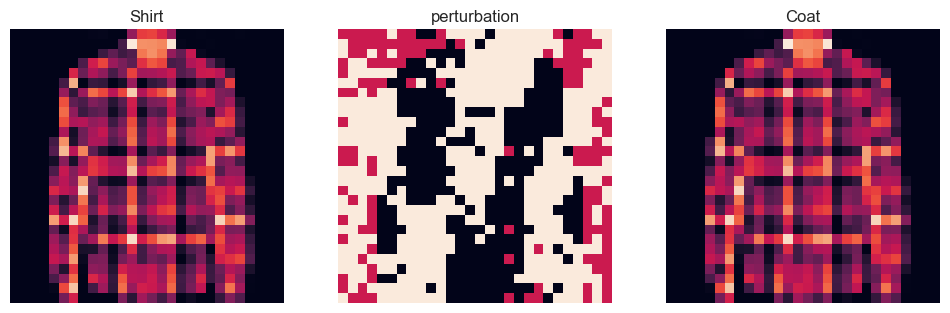

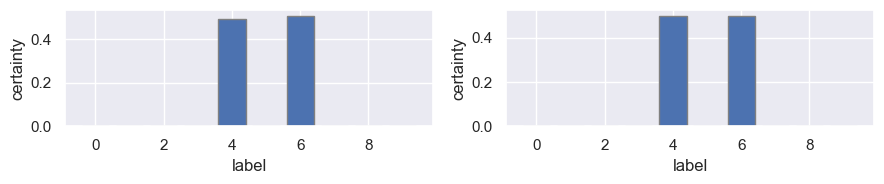

In [117]:
IMG_NR = 7
show_diffs(model, images[IMG_NR].view(1,1,28,28), raw[19][IMG_NR].view(1,1,28,28), fashion_labels)

In [78]:
fb.distances.l2(raw[0], raw[19])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

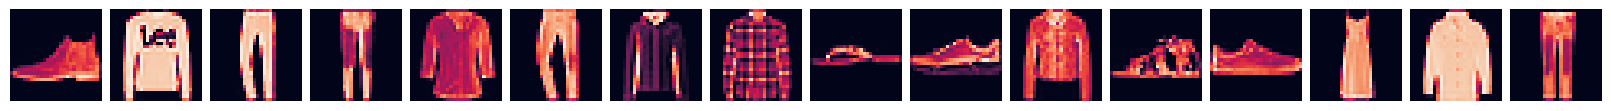

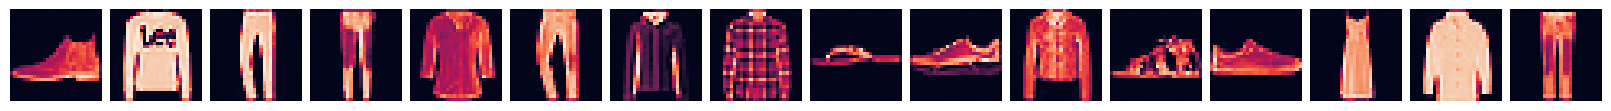

In [81]:
fb.plot.images(images=clipped[0])
fb.plot.images(images=clipped[19])

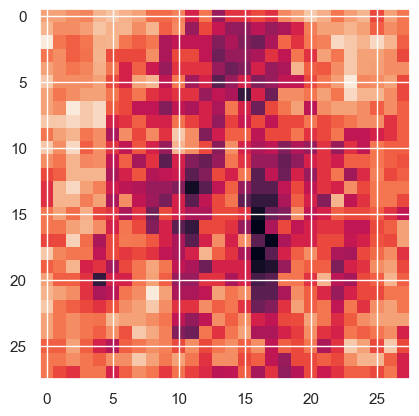

In [170]:
universal_perturbation = torch.sum(raw[14] - images,dim=[0,1])
up = universal_perturbation.view(1,1,28,28)
plt.imshow(universal_perturbation.cpu())

In [108]:
up = universal_perturbation.view(1,1,28,28)


In [54]:
# Difference plotting function
def show_diffs(model, original_tensor, modified_tensor, label_names):
    # Images and predictions
    original_image = original_tensor.view(28, 28).detach().cpu()
    modified_image = modified_tensor.view(28, 28).detach().cpu()
    original_label = model(original_tensor)[0].argmax().item()
    modified_label = model(modified_tensor)[0].argmax().item()
    # Prepare figure
    n_rows, n_cols = 1, 3
    image_figure, image_axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    plot_figure, plot_axes = plt.subplots(n_rows, n_cols-1, figsize=(n_cols * 3, n_rows * 2), sharex=True)

    # Show original image
    ax = image_axes[0]
    ax.imshow(original_image)
    ax.grid(False); ax.axis('off'); ax.set_title(label_names[original_label].split(',')[0])

    # Show perturbation
    ax = image_axes[1]
    ax.imshow(calc_perturbation(original_image, modified_image))
    ax.grid(False); ax.axis('off'); ax.set_title('perturbation')

    # Show perturbed image
    ax = image_axes[2]
    ax.imshow(modified_image)
    ax.grid(False); ax.axis('off'); ax.set_title(label_names[modified_label].split(',')[0])

    original_certainty = F.softmax(model(original_tensor)[0], dim=0).detach().cpu().numpy()
    ax = plot_axes[0]
    ax.bar(range(len(label_names)), original_certainty, edgecolor='gray')
    ax.set_xlabel('label'); ax.set_ylabel('certainty')

    modified_certainty = F.softmax(model(modified_tensor)[0], dim=0).detach().cpu().numpy()
    ax = plot_axes[1]
    ax.bar(range(len(label_names)), modified_certainty, edgecolor='gray')
    ax.set_xlabel('label'); ax.set_ylabel('certainty')

    plt.tight_layout()

def calc_perturbation(original_image, modified_image):
    perturbation = modified_image - original_image
    perturbation -= perturbation.min()
    perturbation /= perturbation.max()
    return perturbation

In [31]:
def calc_universal_perturbation(model, attack, fmodel, epsilon, original_images):
    universal_perturbation = torch.zeros(1,1,28,28)
    for original_image in original_images:
        img = original_image.view(1,1,28,28)
        modified_tensor = original_image.cpu() + universal_perturbation.cpu()
        original_label = model(original_image)[0].argmax().item()
        modified_label = model(modified_tensor)[0].argmax().item()
        if(original_label == modified_label):
            raw, clipped, is_adv = attack(fmodel, modified_tensor, original_label, epsilons=epsilon)
            universal_perturbation = raw - original_image
    return universal_perturbation
        

In [33]:
original_images, labels = fb.utils.samples(fmodel, dataset='fashionMNIST', batchsize=16)
up = calc_universal_perturbation(model, attack, fmodel, 0.02, original_images)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x16 and 256x128)

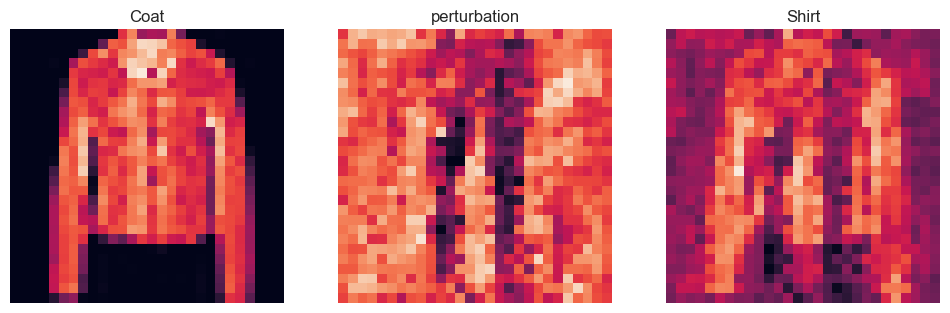

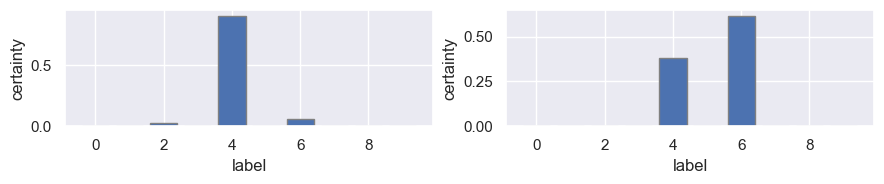

In [146]:
im, lbl = fb.utils.samples(fmodel, dataset='fashionMNIST', index=10)

show_diffs(model, im, im + up, fashion_labels)

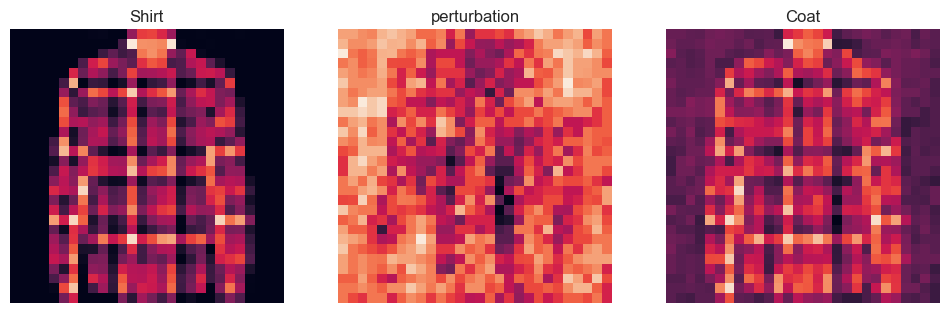

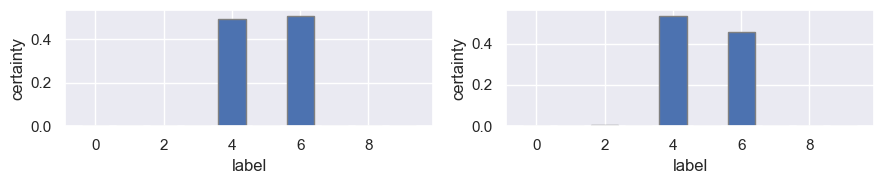

In [171]:
#IMG=7

im, lbl = fb.utils.samples(fmodel, dataset='fashionMNIST', index=7)

show_diffs(model, im, im + up, fashion_labels)

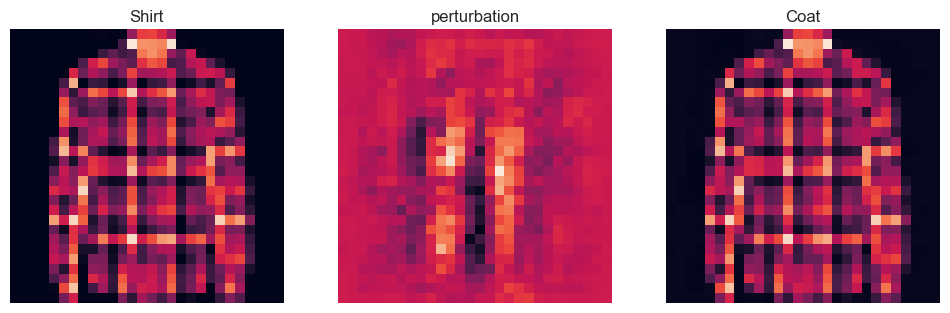

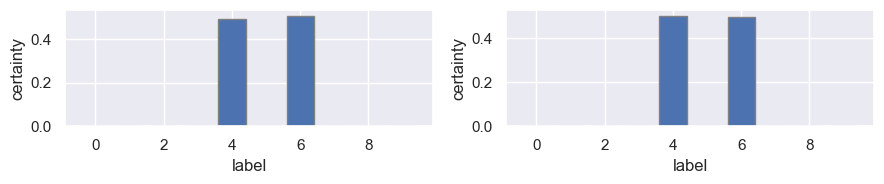

In [214]:
images, labels = fb.utils.samples(fmodel, dataset='fashionMNIST', batchsize=64)
attack = fb.attacks.L2DeepFoolAttack()
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.01)
universal_perturbation = torch.mean(raw - images,dim=[0,1])
up = universal_perturbation.view(1,1,28,28)

#IMG=7

im, lbl = fb.utils.samples(fmodel, dataset='fashionMNIST', index=7)

show_diffs(model, im, im - up, fashion_labels)